# [Project 3: Camera Calibration and Fundamental Matrix Estimation with RANSAC](https://www.cc.gatech.edu/~hays/compvision/proj3)


(1) Camera Projection Matrix  
(2) Fundamental Matrix Estimation  
(3) Fundamental Matrix with RANSAC  

## Setup

In [1]:
%matplotlib notebook
# %load_ext autoreload
# %autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import student_code as sc

## Part 1: Camera Projection Matrix

In [5]:
# Load the data
points_2d = np.loadtxt('../data/pts2d-norm-pic_a.txt')
points_3d = np.loadtxt('../data/pts3d-norm.txt')

# (Optional) Uncomment these four lines once you have your code working with the easier, normalized points above.
# points_2d = np.loadtxt('../data/pts2d-norm-pic_b.txt')
# points_3d = np.loadtxt('../data/pts3d.txt')

### Calculate the projection matrix given corresponding 2D & 3D points

The projection matrix is
 [[ 0.76785834 -0.49384797 -0.02339781  0.00674445]
 [-0.0852134  -0.09146818 -0.90652332 -0.08775678]
 [ 0.18265016  0.29882917 -0.07419242  1.        ]]
The total residual is 0.044535


<IPython.core.display.Javascript object>


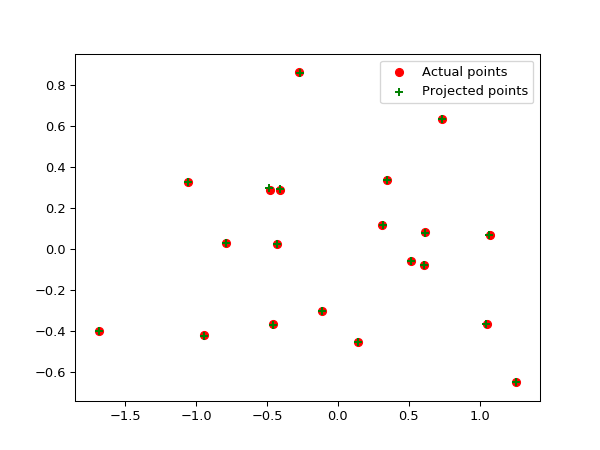

In [6]:
M = sc.calculate_projection_matrix(points_2d, points_3d)
# M = calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', M)

[projected_2d_pts, residual] = evaluate_points(M, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points(points_2d, projected_2d_pts)

### Calculate the camera center using M found from the previous step

In [7]:
def calculate_camera_center(M):
    """
    Returns the camera center matrix for a given projection matrix.

    The center of the camera C can be found by:

        C = -Q^(-1)m4

    where your project matrix M = (Q | m4).

    Args:
    -   M: A numpy array of shape (3, 4) representing the projection matrix

    Returns:
    -   cc: A numpy array of shape (1, 3) representing the camera center
            location in world coordinates
    """

    # Placeholder camera center. In the visualization, you will see this camera
    # location is clearly incorrect, placing it in the center of the room where
    # it would not see all of the points.
    cc = np.asarray([1, 1, 1])

    ###########################################################################
    # TODO: YOUR CAMERA CENTER CALCULATION CODE HERE
    ###########################################################################

    cc = -np.linalg.inv(M[:, :3]).dot(M[:, 3])

    ###########################################################################
    # END OF YOUR CODE
    ###########################################################################

    return cc

The estimated location of the camera is <-1.5126, -2.3517, 0.2827>


<IPython.core.display.Javascript object>


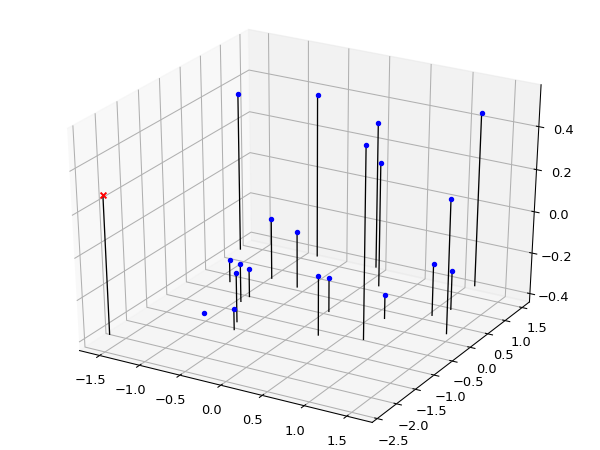

In [8]:
center = sc.calculate_camera_center(M);
print('The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>'.format(*center))
plot3dview(points_3d, center)

## Part 2: Fundamental Matrix Estimation

In [9]:
# Load the data
points_2d_pic_a = np.loadtxt('../data/pts2d-pic_a.txt')
points_2d_pic_b = np.loadtxt('../data/pts2d-pic_b.txt')
img_left = load_image('../data/pic_a.jpg')
img_right = load_image('../data/pic_b.jpg')

### Estimate fundamental matrix

<IPython.core.display.Javascript object>


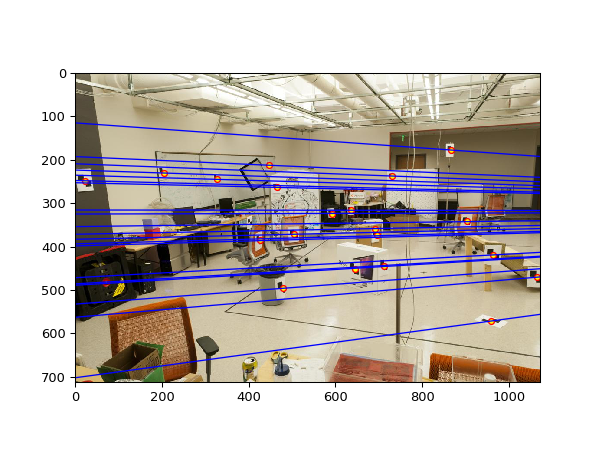

<IPython.core.display.Javascript object>


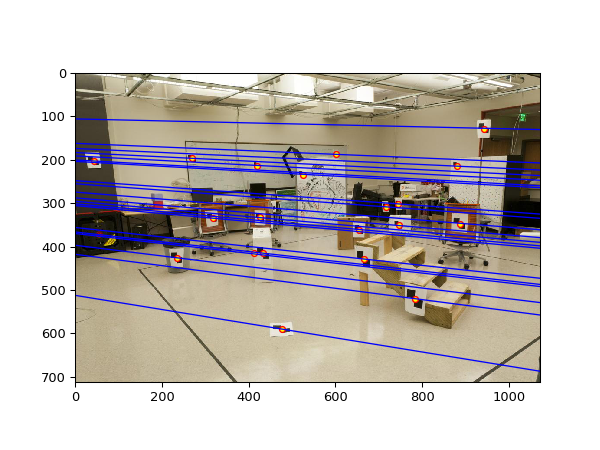

In [11]:
F = sc.estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)
# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_left, img_right, points_2d_pic_a, points_2d_pic_b)

## Part 3: Fundamental Matrix with RANSAC (Szeliski 6.1.4)

**Mount Rushmore**: This pair is easy, and most of the initial matches are correct. The base fundamental matrix estimation without coordinate normalization will work fine with RANSAC. 

**Notre Dame**: This pair is difficult because the keypoints are largely on the same plane. Still, even an inaccurate fundamental matrix can do a pretty good job of filtering spurious matches.  

**Gaudi**: This pair is difficult and doesn't find many correct matches unless you run at high resolution, but that will lead to tens of thousands of ORB features, which will be somewhat slow to process. Normalizing the coordinates seems to make this pair work much better.  

**Woodruff**: This pair has a clearer relationship between the cameras (they are converging and have a wide baseline between them). The estimated fundamental matrix is less ambiguous and you should get epipolar liens qualitatively similar to part 2 of the project.

In [43]:
# Load the data
# Mount Rushmore
# pic_a = load_image('../data/Mount Rushmore/9193029855_2c85a50e91_o.jpg'); scale_a = 0.25
# pic_b = load_image('../data/Mount Rushmore/7433804322_06c5620f13_o.jpg'); scale_b = 0.37
# n_feat = 5e4

# Notre Dame
pic_a = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg'); scale_a = 0.5
pic_b = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg'); scale_b = 0.5
n_feat = 8e3

# Gaudi
# pic_a = load_image('../data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg'); scale_a = 0.8
# pic_b = load_image('../data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg'); scale_b = 1.0
# n_feat = 2e4

# Woodruff
# pic_a = load_image('../data/Woodruff Dorm/wood1.jpg'); scale_a = 0.65
# pic_b = load_image('../data/Woodruff Dorm/wood2.jpg'); scale_b = 0.65
# n_feat = 5e4

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)

Found 1282 possibly matching features


<IPython.core.display.Javascript object>


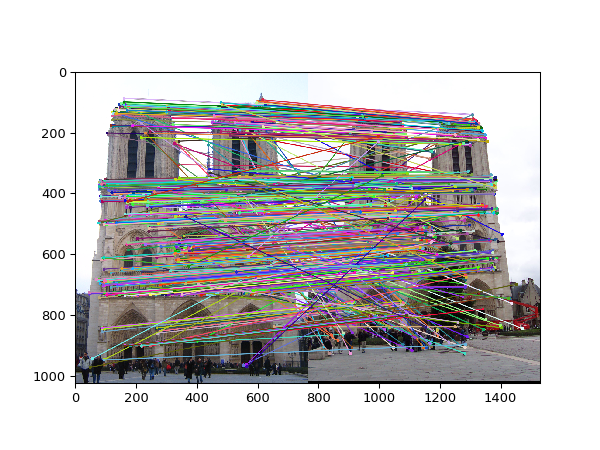

In [44]:
# Finds matching points in the two images using OpenCV's implementation of ORB.
# There can still be many spurious matches, though.
points_2d_pic_a, points_2d_pic_b = get_matches(pic_a, pic_b, n_feat)
print('Found {:d} possibly matching features'.format(len(points_2d_pic_a)))
match_image = show_correspondence2(pic_a, pic_b,
                                   points_2d_pic_a[:, 0], points_2d_pic_a[:, 1],
                                   points_2d_pic_b[:, 0], points_2d_pic_b[:, 1])
plt.figure(); plt.imshow(match_image)

### Calculate the Fundamental Matrix using RANSAC

In [129]:
def estimate_fundamental_matrix(points_a, points_b):
    num = points_a.shape[0]
    A = np.zeros((num, 8))
    ones = np.ones((num, 1))
    
    cu_a = np.mean(points_a[:, 0])
    cv_a = np.mean(points_a[:, 1])
    s_a = np.std(points_a - np.mean(points_a))
    Ta = np.mat([[1/s_a, 0, 0], [0, 1/s_a, 0], [0, 0, 1]]) * np.mat([[1, 0, -cu_a], [0,1,-cv_a], [0, 0, 1]])
    Ta = np.array(Ta)
    points_a = np.hstack([points_a, ones])
    
    cu_b = np.mean(points_a[:, 0])
    cv_b = np.mean(points_a[:, 1])
    s_b = np.std(points_a - np.mean(points_a))
    Tb = np.mat([[1/s_b, 0, 0], [0, 1/s_b, 0], [0, 0, 1]]) * np.mat([[1, 0, -cu_b], [0,1,-cv_b], [0, 0, 1]])
    Tb = np.array(Tb)
    points_b = np.hstack([points_b, ones])
    
    for i in range(num):
        points_a[i] = np.matmul(Ta, points_a[i])
        points_b[i] = np.matmul(Tb, points_b[i])
        
        u1 = points_a[i, 0]
        v1 = points_a[i, 1]
        u2 = points_b[i, 0]
        v2 = points_b[i, 1]
        A[i] = [u1*u2, v1*u2, u2, u1*v2, v1*v2, v2, u1, v1]
    
    A = np.hstack([A, ones])
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
    
    (U, S, V) = np.linalg.svd(F)
    S[2] = 0
    F = U.dot(np.diag(S)).dot(V)
    F = F/F[2,2]
    
    return Tb.T.dot(F).dot(Ta)

In [6]:
def ransac_fundamental_matrix(matches_a, matches_b):
    # Placeholder values
    best_F = estimate_fundamental_matrix(matches_a[:10, :], matches_b[:10, :])
    inliers_a = matches_a[:100, :]
    inliers_b = matches_b[:100, :]

    ###########################################################################
    # TODO: YOUR RANSAC CODE HERE
    ###########################################################################
    k = 2000 # maximum iterations allowed in the algorithm
    n = 10 # the minimum number of data values required to fit the model
    threshold = 0.05 # the number of close data values required to assert that a model fits well to data
    iters = 0
    # bestF
    besterr = np.inf
    bestinlier = []
    
    # 3. threshold on how many points is inlier      
    while iters < k:
        inliers = []
        # 1. sample n rows
        index = [np.random.randint(low = 0, high = len(matches_a)) for i in range(10)]
        sample_a = matches_a[index]
        sample_b = matches_b[index]
        # 2. calculate the F
        F = estimate_fundamental_matrix(sample_a, sample_b)
        for i in range(len(matches_a)):
        # calculate the distance between each transformed point
            x = np.hstack([matches_a[i], 1])
            x_= np.hstack([matches_b[i], 1])
            dis_mat = np.abs(x.dot(F.T).dot(x_.T)) # need abs?
            if dis_mat < threshold:
                inliers.append([dis_mat, matches_a[i], matches_b[i]])
        
        if len(inliers) > len(bestinlier):
            bestinlier = inliers
            bestF = F
        iters += 1
    
    for i in range(min(100, len(bestinlier))):
        inliers_a[i, :] = bestinlier[i][1]
        inliers_b[i, :] = bestinlier[i][2]

    ###########################################################################
    # END OF YOUR CODE
    ###########################################################################

    return best_F, inliers_a, inliers_b

<IPython.core.display.Javascript object>


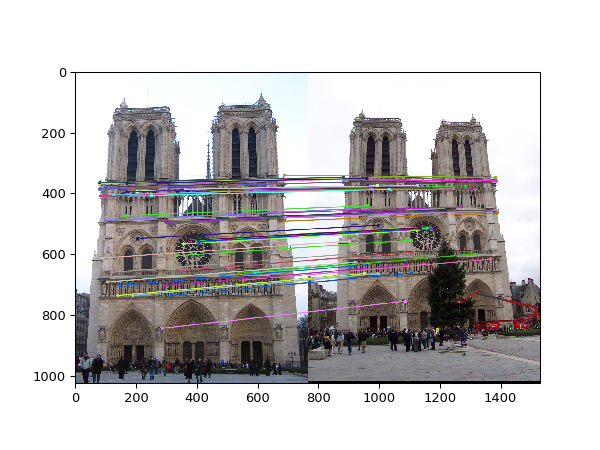

<IPython.core.display.Javascript object>


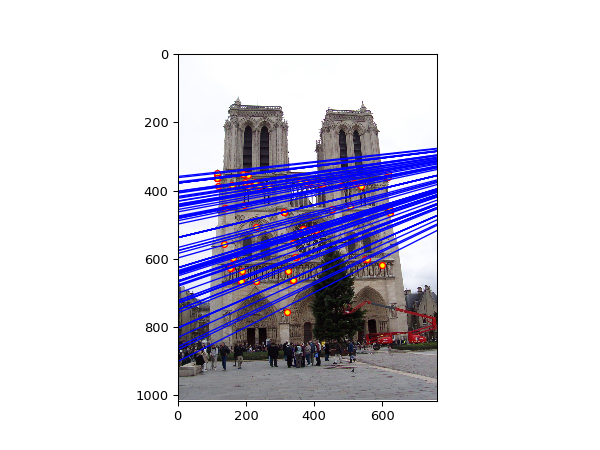

<IPython.core.display.Javascript object>


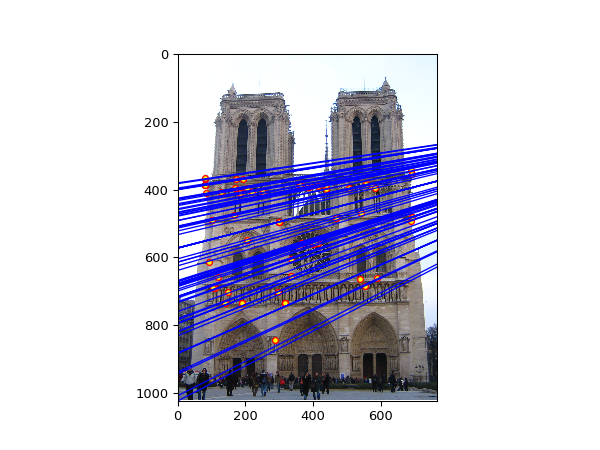

In [54]:
F, matched_points_a, matched_points_b = sc.ransac_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw the epipolar lines on the images and corresponding matches
match_image = show_correspondence2(pic_a, pic_b,
                                   matched_points_a[:, 0], matched_points_a[:, 1],
                                   matched_points_b[:, 0], matched_points_b[:, 1])
plt.figure(); plt.imshow(match_image); plt.savefig("../html/100.jpg")
draw_epipolar_lines(F, pic_a, pic_b, matched_points_a, matched_points_b)

In [ ]:
def calculate_projection_matrix(points_2d, points_3d):
    """
    To solve for the projection matrix. You need to set up a system of
    equations using the corresponding 2D and 3D points:

                                                      [ M11      [ u1
                                                        M12        v1
                                                        M13        .
                                                        M14        .
    [ X1 Y1 Z1 1 0  0  0  0 -u1*X1 -u1*Y1 -u1*Z1        M21        .
      0  0  0  0 X1 Y1 Z1 1 -v1*X1 -v1*Y1 -v1*Z1        M22        .
      .  .  .  . .  .  .  .    .     .      .       *   M23   =    .
      Xn Yn Zn 1 0  0  0  0 -un*Xn -un*Yn -un*Zn        M24        .
      0  0  0  0 Xn Yn Zn 1 -vn*Xn -vn*Yn -vn*Zn ]      M31        .
                                                        M32        un
                                                        M33 ]      vn ]

    Then you can solve this using least squares with np.linalg.lstsq() or SVD.
    Notice you obtain 2 equations for each corresponding 2D and 3D point
    pair. To solve this, you need at least 6 point pairs.

    Args:
    -   points_2d: A numpy array of shape (N, 2)
    -   points_2d: A numpy array of shape (N, 3)

    Returns:
    -   M: A numpy array of shape (3, 4) representing the projection matrix
    """

    # Placeholder M matrix. It leads to a high residual. Your total residual
    # should be less than 1.
    M = np.asarray([[0.1768, 0.7018, 0.7948, 0.4613],
                    [0.6750, 0.3152, 0.1136, 0.0480],
                    [0.1020, 0.1725, 0.7244, 0.9932]])

    ###########################################################################
    # TODO: YOUR PROJECTION MATRIX CALCULATION CODE HERE
    ###########################################################################
    # points_2d = (ui, vi)
    # points_3d = (Xi, Yi, Zi)
    A = np.zeros((points_2d.shape[0]*2, 11))
    for i in range(0, A.shape[0], 2):
        j = i // 2
        
        # u
        A[i][0] = points_3d[j][0] # X1
        A[i][1] = points_3d[j][1] # Y1
        A[i][2] = points_3d[j][2] # Z1
        A[i][3] = 1
        A[i][4:8] = 0
        A[i][8] = -points_2d[j][0]*points_3d[j][0]
        A[i][9] = -points_2d[j][0]*points_3d[j][1]
        A[i][10] = -points_2d[j][0]*points_3d[j][2]
        
        # v
        A[i+1][:4] = 0
        A[i+1][4] = points_3d[j][0]
        A[i+1][5] = points_3d[j][1]
        A[i+1][6] = points_3d[j][2]
        A[i+1][7] = 1
        A[i+1][8] = -points_2d[j][1]*points_3d[j][0]
        A[i+1][9] = -points_2d[j][1]*points_3d[j][1]
        A[i+1][10] = -points_2d[j][1]*points_3d[j][2] 
    right = points_2d.flatten()
    evM = np.linalg.lstsq(A, right, rcond=None)   
    result = np.append(evM[0], 1)
    result = result.reshape(3, 4)
    M = result
    ###########################################################################
    # END OF YOUR CODE
    ###########################################################################
    
    return M
M = calculate_projection_matrix(points_2d, points_3d)

In [ ]:
from numpy import *
def compute_fundamental(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] """

    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    # build matrix for equations
    A = zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
    print(A)
    # compute linear least square solution
    U,S,V = linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = linalg.svd(F)
    S[2] = 0
    F = dot(U,dot(diag(S),V))
    
    return F/F[2,2]
def compute_fundamental_normalized(x1, x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the normalized 8 point algorithm. """
    

    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    x1 = np.hstack([x1, np.ones((x1.shape[0], 1))]).T
    x2 = np.hstack([x2, np.ones((x2.shape[0], 1))]).T
    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = mean(x1[:2],axis=1)
    S1 = sqrt(2) / std(x1[:2])
    T1 = array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])

    x1 = dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = mean(x2[:2],axis=1)
    S2 = sqrt(2) / std(x2[:2])
    T2 = array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = dot(T2,x2)
    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = dot(T2.T,dot(F,T1))
    
    return F/F[2,2]
F = compute_fundamental_normalized(points_2d_pic_a, points_2d_pic_b)

In [107]:
def estimate_fundamental_matrix(points_a, points_b):
    """
    Calculates the fundamental matrix. Try to implement this function as
    efficiently as possible. It will be called repeatedly in part 3.

    You must normalize your coordinates through linear transformations as
    described on the project webpage before you compute the fundamental
    matrix.

    Args:
    -   points_a: A numpy array of shape (N, 2) representing the 2D points in
                  image A
    -   points_b: A numpy array of shape (N, 2) representing the 2D points in
                  image B

    Returns:
    -   F: A numpy array of shape (3, 3) representing the fundamental matrix
    """

    # Placeholder fundamental matrix
    F = np.asarray([[0, 0, -0.0004],
                    [0, 0, 0.0032],
                    [0, -0.0044, 0.1034]])

    ###########################################################################
    # TODO: YOUR FUNDAMENTAL MATRIX ESTIMATION CODE HERE
    ###########################################################################
    # normalization
    
#     a_center = np.mean(points_a, axis=0)
#     a_s = np.sqrt(1/(2*points_a.shape[0])*(np.sum(np.square(points_a[:, 0]-a_center[0]) + np.square(points_a[:, 1]-a_center[1]))))
#     b_center = np.mean(points_b, axis=0)
#     b_s = np.sqrt(1/(2*points_b.shape[0])*(np.sum(np.square(points_b[:, 0]-b_center[0]) + np.square(points_b[:, 1]-b_center[1]))))
#     Ta = np.array([[a_s, 0, 0], [0, a_s, 0], [0, 0, 1]]).dot(np.array([[1, 0, -a_center[0]], [0, 1, -a_center[1]], [0, 0, 1]]))
#     Tb = np.array([[b_s, 0, 0], [0, b_s, 0], [0, 0, 1]]).dot(np.array([[1, 0, -b_center[0]], [0, 1, -b_center[1]], [0, 0, 1]]))
    points_a = np.hstack([points_a, np.ones((points_a.shape[0], 1))])
    points_b = np.hstack([points_b, np.ones((points_b.shape[0], 1))])
    x1, Ta = normalise2dpts(points_a.T)
    x2, Tb = normalise2dpts(points_b.T)
#     A = np.zeros((points_a.shape[0], 9))
    # write down the system of equations|
#     for i in range(points_a.shape[0]):
#         A[i] = [points_a[i][0]*points_b[i][0], points_a[i][0]*points_b[i][1], points_a[i][0], 
#                 points_a[i][1]*points_b[i][0], points_a[i][1]*points_b[i][1], points_a[i][1],
#                 points_b[i][0], points_b[i][1], 1]

#     A = np.array([b[0, :].T*a[0, :].T, b[0, :].T*a[1, :].T, b[0, :].T, 
#                   b[1, :].T*a[0, :].T, b[1, :].T*a[1, :].T, b[1, :].T,
#                   a[0, :].T, a[1, :].T, [1]*20]).T
    
#     n = x1.shape[1]
#     if x2.shape[1] != n:
#         raise ValueError("Number of points don't match.")
    
    # build matrix for equations
#     A = np.zeros((n, 8))
#     for i in range(n):
#         A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
#                 x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
#                 x1[2,i]*x2[0,i], x1[2,i]*x2[1,i]]

#     _, _, V = np.linalg.svd(A)
#     F = V[-1].reshape(3,3)
    num = points_a.shape[0]
    A = np.ones((num, 9))
    for i in range(num):
        u1 = x1[0, i]
        v1 = x1[1, i]
        u2 = x2[0, i]
        v2 = x2[1, i]
        A[i, :8] = [u1*u2, v1*u2, u2, u1*v2, v1*v2, v2, u1, v1]
#     F = np.linalg.lstsq(A, -B, rcond=-1)[0]
#     F = np.vstack((F, 1))
#     F = F.reshape(3, 3)
    _, _, V = np.linalg.svd(A) 
    F = V[-1].reshape(3,3)
    
    (U, S, V) = np.linalg.svd(F)
    S[2] = 0
    F = U.dot(np.diag(S)).dot(V)
    F = F/F[2,2]
    ###########################################################################
    # END OF YOUR CODE
    ###########################################################################

    return Tb.T.dot(F).dot(Ta)
F = estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

In [106]:
def normalise2dpts(pts):
    """
    Function translates and normalises a set of 2D homogeneous points 
    so that their centroid is at the origin and their mean distance from 
    the origin is sqrt(2).  This process typically improves the
    conditioning of any equations used to solve homographies, fundamental
    matrices etc.
       
       
    Inputs:
    pts: 3xN array of 2D homogeneous coordinates
   
    Returns:
    newpts: 3xN array of transformed 2D homogeneous coordinates.  The
            scaling parameter is normalised to 1 unless the point is at
            infinity. 
    T: The 3x3 transformation matrix, newpts = T*pts
    """
    if pts.shape[0] != 3:
        print("Input shoud be 3")

    finiteind = np.nonzero(abs(pts[2,:]) > np.spacing(1));
    
#     if len(finiteind) != pts.shape[1]:
#         print('Some points are at infinity')
    
    dist = []
    for i in finiteind:
        pts[0,i] = pts[0,i]/pts[2,i]
        pts[1,i] = pts[1,i]/pts[2,i]
        pts[2,i] = 1;
        c = np.mean(pts[0:2,i].T, axis=0).T          
        newp1 = pts[0,i]-c[0]
        newp2 = pts[1,i]-c[1]
        dist.append(np.sqrt(newp1**2 + newp2**2))
        
    meandist = np.mean(dist[:])
    scale = np.sqrt(2)/meandist
    T = np.array([[scale, 0, -scale*c[0]], [0, scale, -scale*c[1]], [0, 0, 1]])
    newpts = T.dot(pts)
    return [newpts, T]

In [ ]:
def estimate_fundamental_matrix(points_a, points_b):
    num = points_a.shape[0]
    A = np.zeros((num, 8))
    B = np.ones((num, 1))
    
    cu_a = np.mean(points_a[:, 0])
    cv_a = np.mean(points_a[:, 1])
    s_a = np.std(points_a - np.mean(points_a))
    Ta = np.mat([[1/s_a, 0, 0], [0, 1/s_a, 0], [0, 0, 1]]) * np.mat([[1, 0, -cu_a], [0,1,-cv_a], [0, 0, 1]])
    Ta = np.array(Ta)
    print(Ta)
estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)